# Task 3: Mitral Valve segmentation

In [1]:
import pickle
import gzip
import numpy as np
import os
import matplotlib.pyplot as plt
from skimage import segmentation
import cv2 as cv
import tensorflow as tf

!pip install keras_unet
from keras_unet.utils import get_augmented


-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


### Helper functions

In [2]:
def load_zipped_pickle(filename):
    with gzip.open(filename, 'rb') as f:
        loaded_object = pickle.load(f)
        return loaded_object

In [3]:
def save_zipped_pickle(obj, filename):
    with gzip.open(filename, 'wb') as f:
        pickle.dump(obj, f, 2)

In [4]:
def evaluate(predictions, targets):
    ious = []
    for p, t in zip(predictions, targets):
        assert p['name'] == t['name']
        prediction = np.array(p['prediction'], dtype=bool)
        target = np.array(t['label'], dtype=bool)

        assert target.shape == prediction.shape
        overlap = prediction*target
        union = prediction + target

        ious.append(overlap.sum()/float(union.sum()))
    
    print("Median IOU: ", np.median(ious))

### Load data and preprocessing

In [5]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/AML3

Mounted at /content/drive
/content/drive/MyDrive/AML3


In [6]:
# load data
train_data = load_zipped_pickle("train.pkl")
test_data = load_zipped_pickle("test.pkl")
#samples = load_zipped_pickle("sample.pkl")

In [7]:
idx = []
for i, image in enumerate(train_data):
    if image['dataset'] == 'expert':
        idx.append(i)


#train_data_expert = [train_data[i] for i in idx]
train_data_expert = train_data

train_images = [train_data_expert[video]['video'][:,:,frame] for video in range(len(train_data_expert)) for frame in range(train_data_expert[video]['video'].shape[2])]
train_labels = [train_data_expert[video]['label'][:,:,frame].astype(float) for video in range(len(train_data_expert)) for frame in range(train_data_expert[video]['label'].shape[2])]

test_images = [test_data[video]['video'][:,:,frame]for video in range(len(test_data)) for frame in range(test_data[video]['video'].shape[2])]





In [8]:
test_names = [test_data[video]['name']for video in range(len(test_data))]
test_frames = [test_data[video]['video'].shape[2] for video in range(len(test_data))]



In [9]:
#find labeled frames
labeled_images = []
for j, labels in enumerate(train_labels):

    if labels.any():
        labeled_images.append(j)

train_images = [train_images[i] for i in labeled_images]
train_labels = [train_labels[i] for i in labeled_images]


In [10]:
#min_shape = min([img.shape[0] if img.shape[0] < img.shape[1] else img.shape[1] for img in train_images])
min_shape = 320
#RESIZE#
resized_img = []
resized_lab = []
for image, label in zip(train_images,train_labels):

    resized_image = cv.resize(image, (min_shape,min_shape), interpolation=cv.INTER_LANCZOS4)
    resized_label = cv.resize(label, (min_shape,min_shape), interpolation=cv.INTER_LANCZOS4)

    #equ = cv.equalizeHist(resized_image)
    #threshed = cv.adaptiveThreshold(equ,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,101,2)
    
    norm_image = cv.normalize(resized_image,  np.zeros(resized_image.shape), 0, 255, cv.NORM_MINMAX)
    #edges = cv.Canny(norm_image,100,200)


    resized_img.append(norm_image)
    resized_lab.append(resized_label)


train_img_exp = np.expand_dims(resized_img, axis = 3)
train_lab_exp = np.expand_dims(resized_lab, axis = 3)



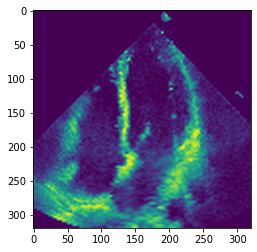

In [11]:
plt.imshow(resized_img[0])

### Model: split training and test, data augmentation and training

In [12]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(train_img_exp, train_lab_exp, test_size=0.05, random_state=0)

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

x_train:  (185, 320, 320, 1)
y_train:  (185, 320, 320, 1)
x_val:  (10, 320, 320, 1)
y_val:  (10, 320, 320, 1)


In [13]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.interpolation import map_coordinates

def elastic_transform(image, alpha_range, sigma, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_.
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
       Convolutional Neural Networks applied to Visual Document Analysis", in
       Proc. of the International Conference on Document Analysis and
       Recognition, 2003.
       
   # Arguments
       image: Numpy array with shape (height, width, channels). 
       alpha_range: Float for fixed value or [lower, upper] for random value from uniform distribution.
           Controls intensity of deformation.
       sigma: Float, sigma of gaussian filter that smooths the displacement fields.
       random_state: `numpy.random.RandomState` object for generating displacement fields.
    """
    
    if random_state is None:
        random_state = np.random.RandomState(None)
        
    if np.isscalar(alpha_range):
        alpha = alpha_range
    else:
        alpha = np.random.uniform(low=alpha_range[0], high=alpha_range[1])

    shape = image.shape
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha

    x, y, z = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), np.arange(shape[2]), indexing='ij')
    indices = np.reshape(x+dx, (-1, 1)), np.reshape(y+dy, (-1, 1)), np.reshape(z, (-1, 1))

    return map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)

data_gen_args = dict(
      rotation_range=.05,
      width_shift_range=0.003,
      height_shift_range=0.003,
      shear_range=20,
      zoom_range=0.05,
      preprocessing_function=lambda x: elastic_transform(x, alpha_range=8, sigma=2),
      horizontal_flip=True,
      vertical_flip=False,
      fill_mode='constant')

batch_size = 32
seed = 0

X_datagen = ImageDataGenerator(**data_gen_args)
Y_datagen = ImageDataGenerator(**data_gen_args)
X_datagen.fit(x_train, augment=True, seed=seed)
Y_datagen.fit(y_train, augment=True, seed=seed)
X_train_augmented = X_datagen.flow(
    x_train, batch_size=batch_size, shuffle=True, seed=seed)
Y_train_augmented = Y_datagen.flow(
    y_train, batch_size=batch_size, shuffle=True, seed=seed)

train_generator = zip(X_train_augmented, Y_train_augmented)
train_gen = train_generator

In [ ]:
train_gen = get_augmented(
    x_train, y_train, batch_size=16,
    data_gen_args = dict(
        rotation_range=.05,
        width_shift_range=0.003,
        height_shift_range=0.003,
        shear_range=20,
        zoom_range=0.05,
        horizontal_flip=True,
        vertical_flip=False,
        fill_mode='constant'
    ))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(32, 320, 320, 1) (32, 320, 320, 1)


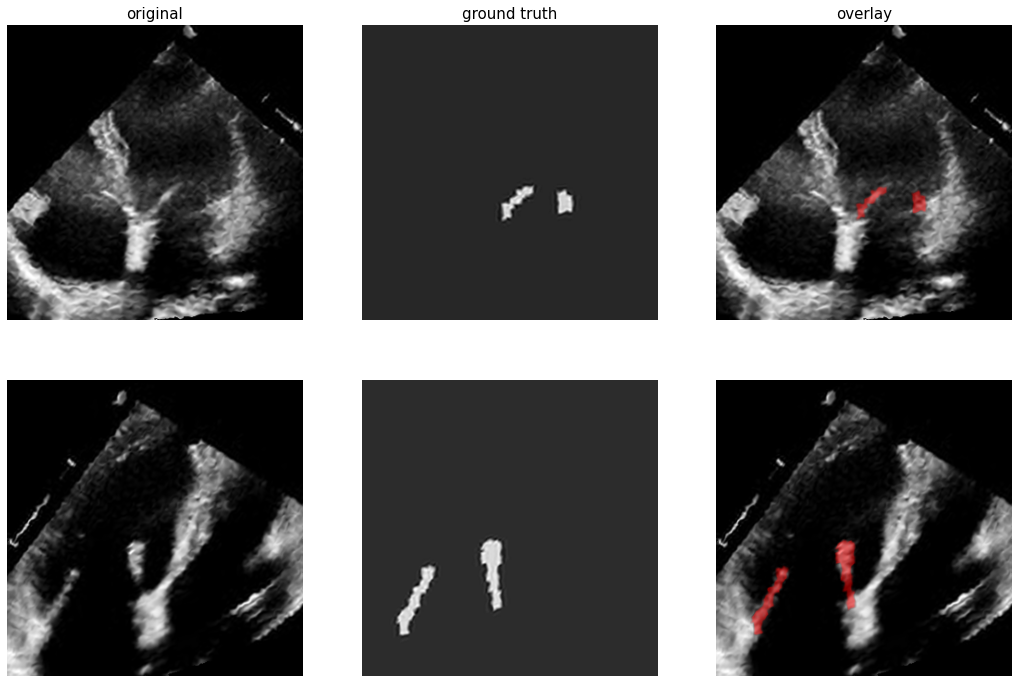

In [14]:
sample_batch = next(train_gen)
xx, yy = sample_batch
print(xx.shape, yy.shape)
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=xx, mask_imgs=yy, nm_img_to_plot=2, figsize=6)

In [15]:
from keras_unet.models import custom_unet

#input_shape = train_lab_exp[0].shape
input_shape = (320,320,1)


model = custom_unet(
    input_shape,
    use_batch_norm=False,
    num_classes=1,
    filters=32,
    dropout=0.05,
    output_activation='sigmoid')

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint


model_filename = 'segm_model_v12.h5'
callback_checkpoint = ModelCheckpoint(
    model_filename, 
    verbose=1, 
    monitor='val_loss', 
    save_best_only=True)

In [17]:
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance

model.compile(
    optimizer=Adam(), 
    #optimizer=SGD(lr=0.01, momentum=0.99),
    loss='binary_crossentropy',
    #loss=jaccard_distance,
    metrics=[iou, iou_thresholded]
)

In [18]:
history = model.fit(
    train_gen,
    steps_per_epoch=50,
    epochs=25,
    
    validation_data=(x_val, y_val),
    callbacks=[callback_checkpoint]
)

Epoch 1/25
50/50 [==============================] - ETA: 0s - loss: 0.6865 - iou: 0.0135 - iou_thresholded: 0.0143
Epoch 00001: val_loss improved from inf to 0.08822, saving model to segm_model_v12.h5
50/50 [==============================] - 253s 4s/step - loss: 0.6865 - iou: 0.0135 - iou_thresholded: 0.0143 - val_loss: 0.0882 - val_iou: 0.0283 - val_iou_thresholded: 0.0328
Epoch 2/25
50/50 [==============================] - ETA: 0s - loss: 0.0532 - iou: 0.0921 - iou_thresholded: 0.0944
Epoch 00002: val_loss improved from 0.08822 to 0.03287, saving model to segm_model_v12.h5
50/50 [==============================] - 150s 3s/step - loss: 0.0532 - iou: 0.0921 - iou_thresholded: 0.0944 - val_loss: 0.0329 - val_iou: 0.1490 - val_iou_thresholded: 0.1680
Epoch 3/25
50/50 [==============================] - ETA: 0s - loss: 0.0331 - iou: 0.1934 - iou_thresholded: 0.2143
Epoch 00003: val_loss improved from 0.03287 to 0.02371, saving model to segm_model_v12.h5
50/50 [==============================

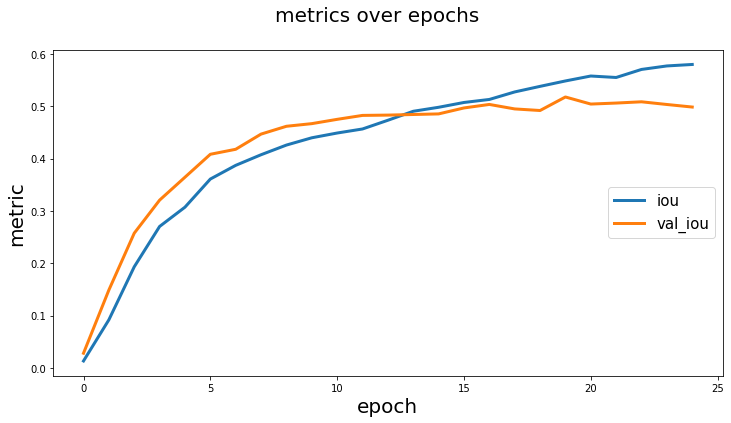

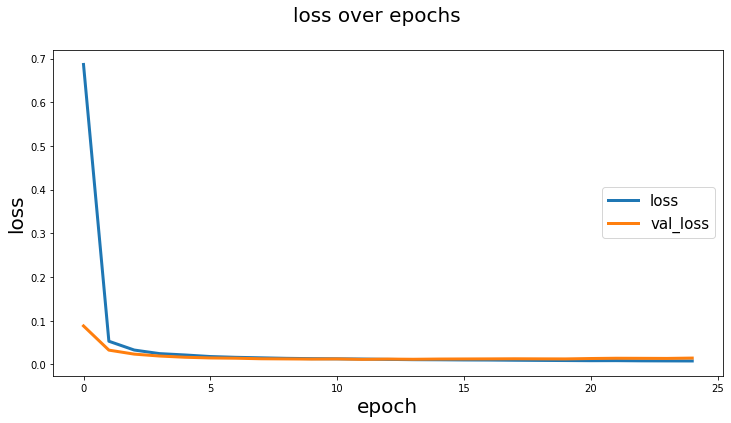

In [19]:
from keras_unet.utils import plot_segm_history

plot_segm_history(history)

In [20]:
#model_filename = 'segm_model_v4.h5'

model.load_weights(model_filename)
y_pred = model.predict(x_val)

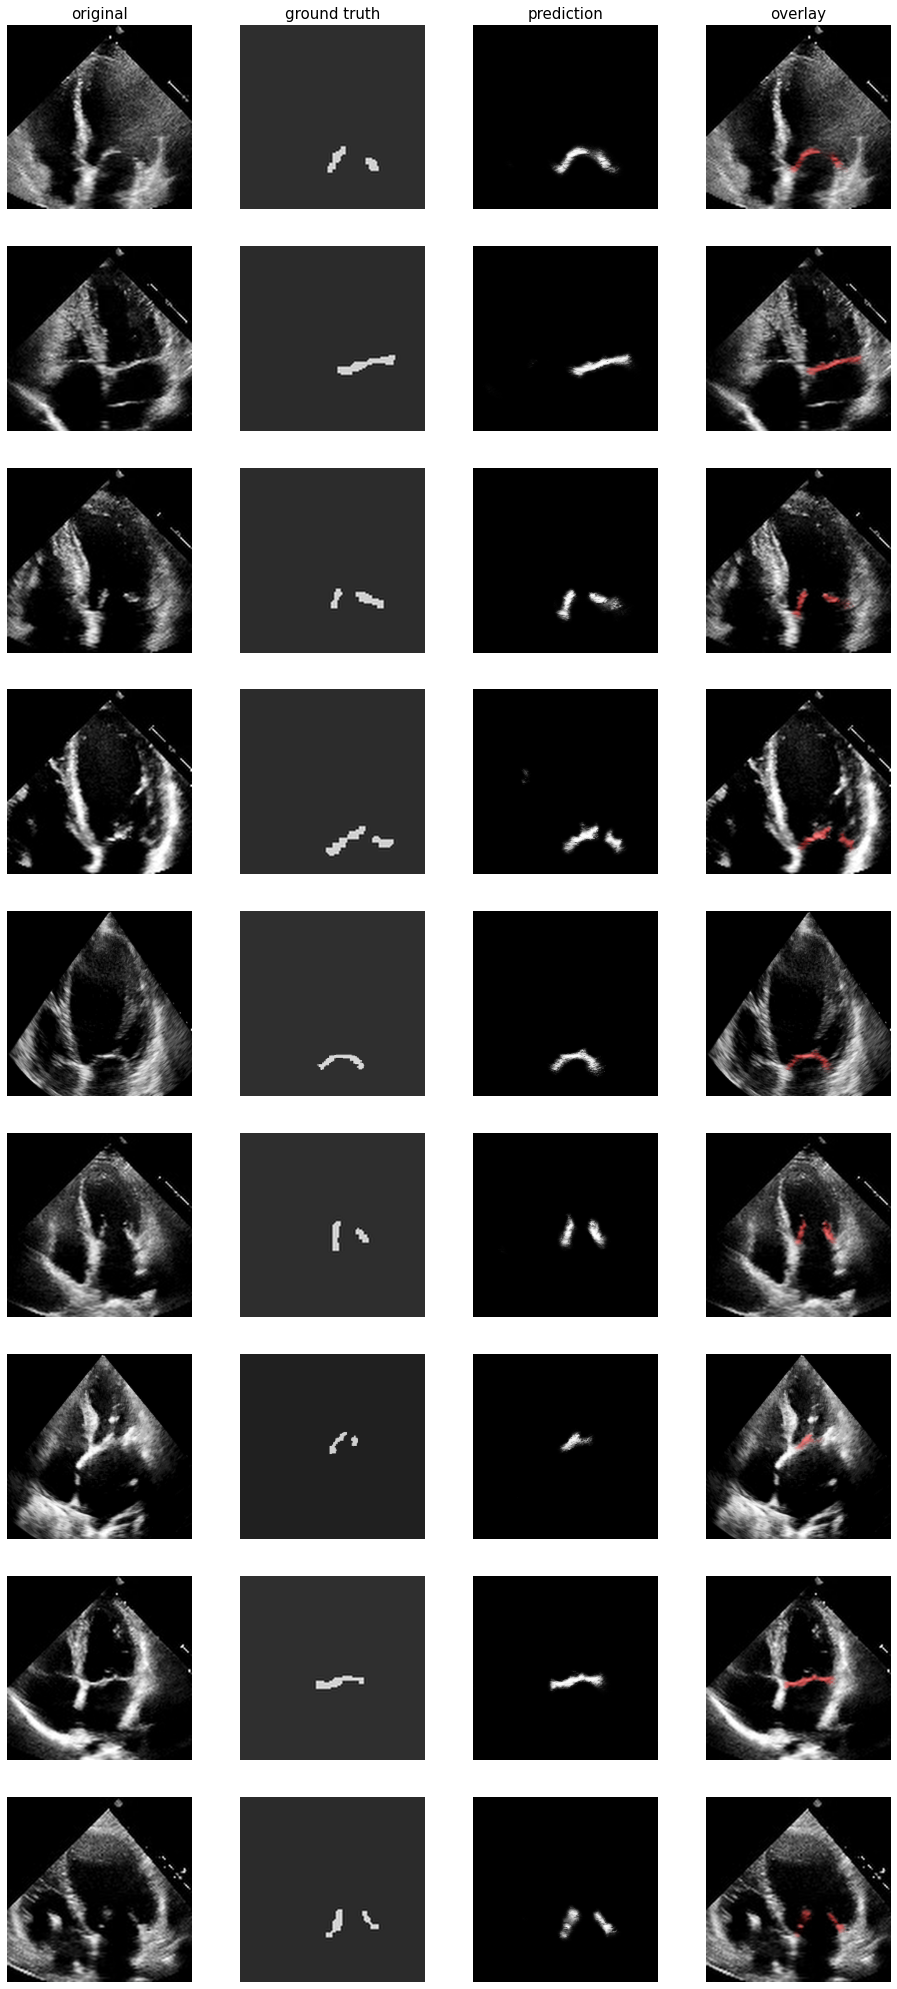

In [21]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=x_val, mask_imgs=y_val, pred_imgs=y_pred, nm_img_to_plot=9)

In [22]:
intersection = np.logical_and(y_pred, y_val)
union = np.logical_or(y_pred, y_val)
iou_score = np.sum(intersection) / np.sum(union)
iou_score

0.05092884894726703

In [23]:
post2 = []
for pred in y_pred:

  pred = np.where(pred > 0.5, 1.,0.)
  post2.append(pred)

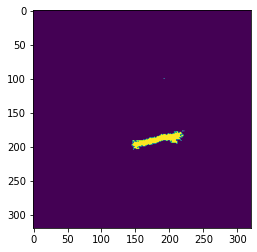

In [25]:
plt.imshow(np.reshape(post2[-1], (320,320)))

In [26]:
from sklearn.cluster import KMeans


post_pred = []
for pred in post2:
  
  #pred = np.reshape(pred.flatten(), (-1, 1))
  #kmeans = KMeans(n_clusters=2, random_state=0).fit(pred)

  #labels = np.reshape(kmeans.labels_, (320,320))
  #labels = np.uint8(labels)
  labels = np.reshape(pred, (320,320))
  labels = np.uint8(labels)

  kernel = cv.getStructuringElement(cv.MORPH_CROSS,(3,3))
  closing = cv.morphologyEx(labels, cv.MORPH_CLOSE, kernel)
  closing = cv.morphologyEx(closing, cv.MORPH_CLOSE, kernel)
  #closing = cv.morphologyEx(closing, cv.MORPH_OPEN, kernel)
  #closing = cv.morphologyEx(closing, cv.MORPH_OPEN, kernel)

  post_pred.append(closing)





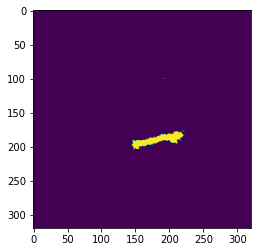

In [27]:
plt.imshow(post_pred[-1])

In [28]:
y_val = np.reshape(y_val,(10,320,320))
prediction = np.where(np.array(post_pred) > 0.5, 1.,0.)
intersection = np.logical_and(prediction, y_val)
union = np.logical_or(prediction, y_val)
iou_score = np.sum(intersection) / np.sum(union)
iou_score

0.25353226774316734

In [30]:
#RESIZE#
min_shape = 320
resized_img_test = []
print(len(test_images))
for image in test_images:

    resized_image_test = cv.resize(image, (min_shape,min_shape), interpolation=cv.INTER_NEAREST)



    norm_image_test = cv.normalize(resized_image_test,  np.zeros(resized_image_test.shape), 0, 255, cv.NORM_MINMAX)
    resized_img_test.append(norm_image_test)


test_img_exp = np.expand_dims(resized_img_test, axis = 3)


1572


In [31]:
#model_filename = 'segm_model_v2.h5'

model.load_weights(model_filename)
pred = model.predict(test_img_exp)

In [33]:
post_test = []
for p in pred:

  p = np.where(p > 0.5, 1,0)
  post_test.append(p)

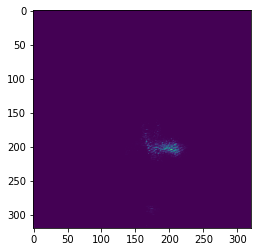

In [34]:
plt.imshow(np.reshape(pred[0], (320,320)))

In [35]:
from sklearn.cluster import KMeans


post_pred_test = []
for p in post_test:
  
  labels = np.reshape(p, (320,320))
  labels = np.uint8(labels)

  kernel = cv.getStructuringElement(cv.MORPH_CROSS,(3,3))
  closing = cv.morphologyEx(labels, cv.MORPH_CLOSE, kernel)

  post_pred_test.append(closing)

In [36]:
#resize

final = []

for resized, orig in zip(post_pred_test, test_images):
      

      original_size = cv.resize(resized, (orig.shape[1], orig.shape[0]), interpolation=cv.INTER_NEAREST)
      
      original_size = np.array(original_size)
      original_size.astype(bool)
      final.append((original_size))



In [37]:
final = [f.astype(bool)for f in final]

print(len(test_images))

print(final[0])


1572
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


## Make prediction for test

In [38]:
predictions = []
current_state = 0
for i, (d,f) in enumerate(zip(test_data, test_frames)):


    prediction = np.array(np.zeros_like(d['video']), dtype=np.bool)
    #height = prediction.shape[0]
    #width = prediction.shape[1]

    for j, p in enumerate(final[current_state:current_state+f]):
      
      prediction[:, :, j] = p
    #prediction = [(list(final[current_state:current_state+f]))
    #prediction = [p for p in final[current_state:current_state+f]]

    current_state += f

    print(len(prediction), f)
    # DATA Strucure
    predictions.append({
        'name': d['name'],
        'prediction': prediction
        }
    )

583 84
582 78
732 53
587 104
587 73
583 159
731 72
583 63
583 90
583 62
583 94
583 68
594 51
583 63
587 125
586 65
730 54
583 106
707 39
583 69


## Save in correct format

In [39]:
save_zipped_pickle(predictions, 'my_predictions02.pkl')